# Wiktor Ciołek 311501 SATFD laboratory 5 30.05.2024

In [34]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import wavfile
from scipy.signal import chirp

import pywt

plt.rcParams['font.size'] = 12

# Introduction
In this exercise the wavelet transform is explored. Both types of wavelet transform are taken into account:
1. **DWT (Discrete Wavelet Transform)** utilizes the fact, that filtering in frequency domain is equivalent to convolution in time domain. Therefore a cascade of Low-Pass and High-Pass filtering is performed. In each iteration of the process (i.e. at each level) High-Pass filtering result is stored as array of coefficients. The filter function is a Wavelet function which is characterized by location in time and finite power. It is denoted as $\Psi_n(t) := \Psi(\frac{t - b}{a})$, where n is the level. LP filter is defined by another, orthogonal to $\Psi$ function called $\Phi$. The result of the Low-Pass filtering is decimated and taken as an input for the next level. After n-levels a set of coefficient is received. Those coefficients fully represent the base function and can be represented on a scalogram.
2. **CWT (Continuous Wavelet Transform)** Continous Wavelet Transform is in theory a sum of convolutions of the base function with a wavelet that is in each sum element unsqueezed or moved along the time axis. Moving along the time domain provides a analysis of all locations of the signal. Scaling the wavelet allows for many frequencies to be recognized in the signal. A frequency that is most present in the Fourier sense in the wavelet is called the central frequency.  

# Wavelet Choice
Daubechies wavelet family is chosen as a wavelet that will be used throughout this exercise. It is plotted along with the corresponding scaling function $\Phi$. Both of their spectra is also plotted. One should notice few things:
* *'db7'* type wavelet is asymmetrical which is useful for changing frequency anlysis
* It is also well located in time as a result of finite power demand
* The spectrum of the scaling function shows low frequencies present there. That's why it can be used as low-pass filter
* There is a frequency that has the most share in wavelet function $\Psi$. This is the central frequency.

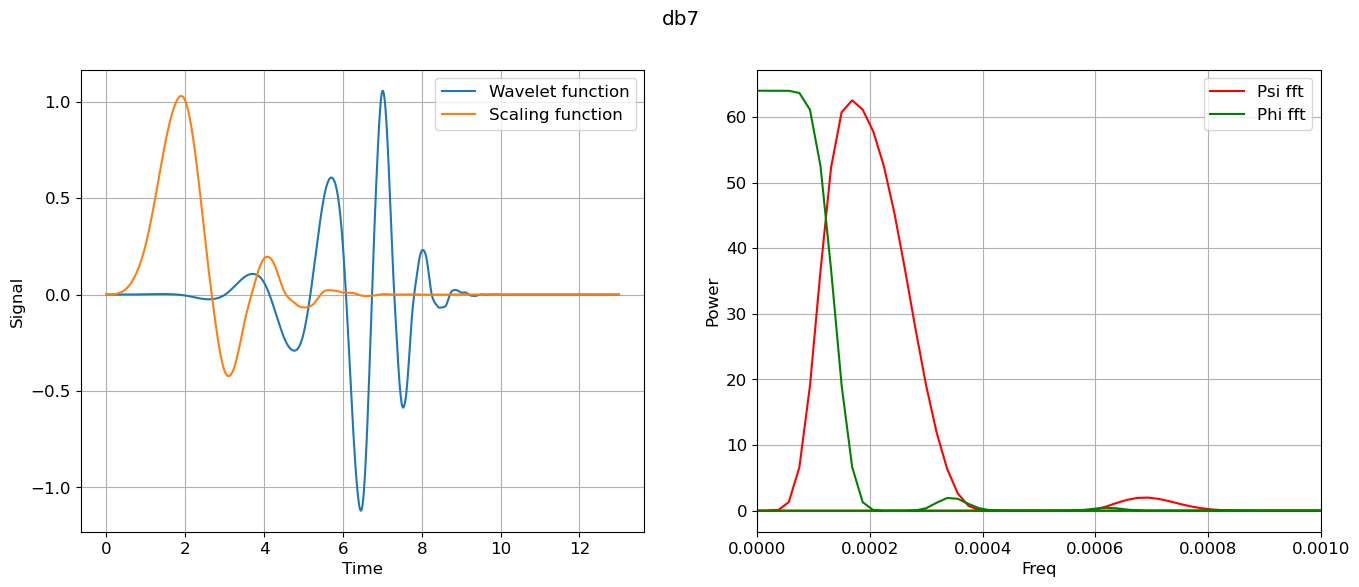

In [35]:
wavelet_type = 'db7'
mirror_filt = lambda x: -(-1) ** np.arange(1, len(x) + 1) * x

wv = pywt.Wavelet(wavelet_type)
phi, psi, x = wv.wavefun(level=6)
wv_mirr = mirror_filt(psi)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(x, psi, label='Wavelet function')
plt.plot(x, phi, label='Scaling function')

plt.xlabel('Time')
plt.ylabel('Signal')
plt.suptitle(wavelet_type)
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
fs = x[-1] / len(psi)
freqs = np.fft.fftfreq(len(psi), 1/fs)
psi_fft = np.abs(np.fft.fft(psi))
phi_fft = np.abs(np.fft.fft(phi))
plt.plot(freqs, psi_fft, 'r-', label='Psi fft')
plt.plot(freqs, phi_fft, 'g-', label='Phi fft')
plt.xlabel('Freq')
plt.ylabel('Power')
plt.legend()
plt.xlim(0, 1e-3)
plt.grid()

plt.show()

# Scalogram plotting functions
Methods for plotting CWT as well as DWT scalogram are implemented in the cell below. In both of them *PyWavelet* module is used. For DWT case each of the coefficients is represented by a rectangle patch on the scalogram. It's height is constanct but each scale level is communicated on y-axis. The width of the patch is changing and given the real-scale of time domain it shows that with greater scale comes lesser time resolution as the wavelet is essentially wider. The difference between the CWT and DWT scalograms is that on the former, y-axis represents the frequency obtained by sufficing method. In DWT case central frequencies for each scale are calculated but are communicated by the side exclusively. Effectively, DWT plot is mirrored upside down with respect to CWT plot.

In [36]:
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle
plt.rcParams['axes.grid'] = False

def plot_dwt_scalogram(signal, wavelet, fs, level = None):
    if level is None:
        level = pywt.dwt_max_level(len(signal), wavelet)
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    fig, ax = plt.subplots(figsize=(22, 8))

    vmax = np.max([np.max(np.abs(c)) for c in coeffs])
    # low frequencies in real signal create very high coefficients making the scalogram unreadable. Check with np.histogram that only <1% of c is greater than that
    if vmax > 20000:
        vmax /= 10
    norm = Normalize(vmin=np.min([np.min(np.abs(c)) for c in coeffs]), vmax=vmax)
    num_levels = len(coeffs) - 1
    height = 1 / num_levels
    scales = 2**np.arange(0, num_levels)
    frequencies = (fs / (scales)) / 2
    for i, coeff in enumerate(coeffs[1:]):
        width = len(signal) / fs / len(coeff)
        colors = plt.cm.magma(norm(np.abs(coeff)))
        y = 1 - (i + 1) * height
        for j in range(len(coeff)):
            x = width * j
            ax.add_patch(Rectangle((x, y), width=width, height=height, facecolor=colors[j]))
    

    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Scale [level]')
    ax.set_title('Scalogram')
    y_ticks = [((i + 0.5) * height) for i in range(num_levels)]
    y_labels = [f'Scale {scale}' for scale in scales]
    ax.set_yticks(y_ticks, y_labels)
    ax.set_xlim(0, len(signal)/fs)

    ax2 = ax.twinx()
    ax2.set_yticks(y_ticks, np.round(frequencies, 7))
    ax2.set_ylabel('Frequency [Hz]')

    fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='magma'), label='Magnitude', ax=ax)

In [37]:
def plot_cwt_scalogram(signal, fs):
    scales = np.arange(1, 2**7)
    coefficients, frequencies = pywt.cwt(signal, scales, pywt.ContinuousWavelet('cmor1.5-1.0'), sampling_period=1/fs)

    # Plot the scalogram
    plt.figure(figsize=(22, 8))
    plt.pcolormesh(np.arange(len(signal)) / fs, frequencies, np.abs(coefficients), cmap='magma')
    plt.colorbar(label='Magnitude')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title('Scalogram (Wavelet Transform)')
    plt.yscale('log')

    plt.show()

In [38]:
def plot_signal(X, T, title):
    plt.plot(T, X, 'k-', linewidth=0.1)
    plt.title(title)
    plt.xlabel('Time [s]')
    plt.ylabel('Signal')
    plt.grid()

    plt.show()

# Chirp signal
First, chirp signal is taken into investigation. It's frequency is increasing in time. We expect higher scales to be more represented at first as they are corresponding to lower frequencies. We also expect a shift towards lower scales and higher frequency. On the scalogram below one can observe that the frequencies describing the chirp signal are indeed present in the wavelet transformation. Both CWT and DWT are in agreement. However, DWT method has much lower resolution, which will be true for all cases. 

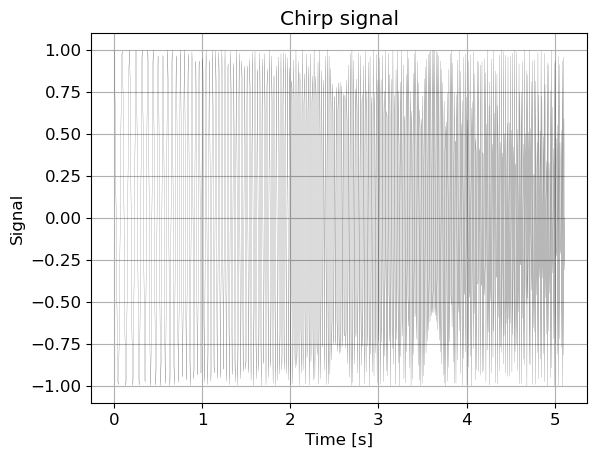

In [39]:
N = 2**10
f1, f2 = 10,90
fs = 200
T = np.arange(N) / fs
X = chirp(T, f1, T[-1], f2)
plot_signal(X, T, 'Chirp signal')

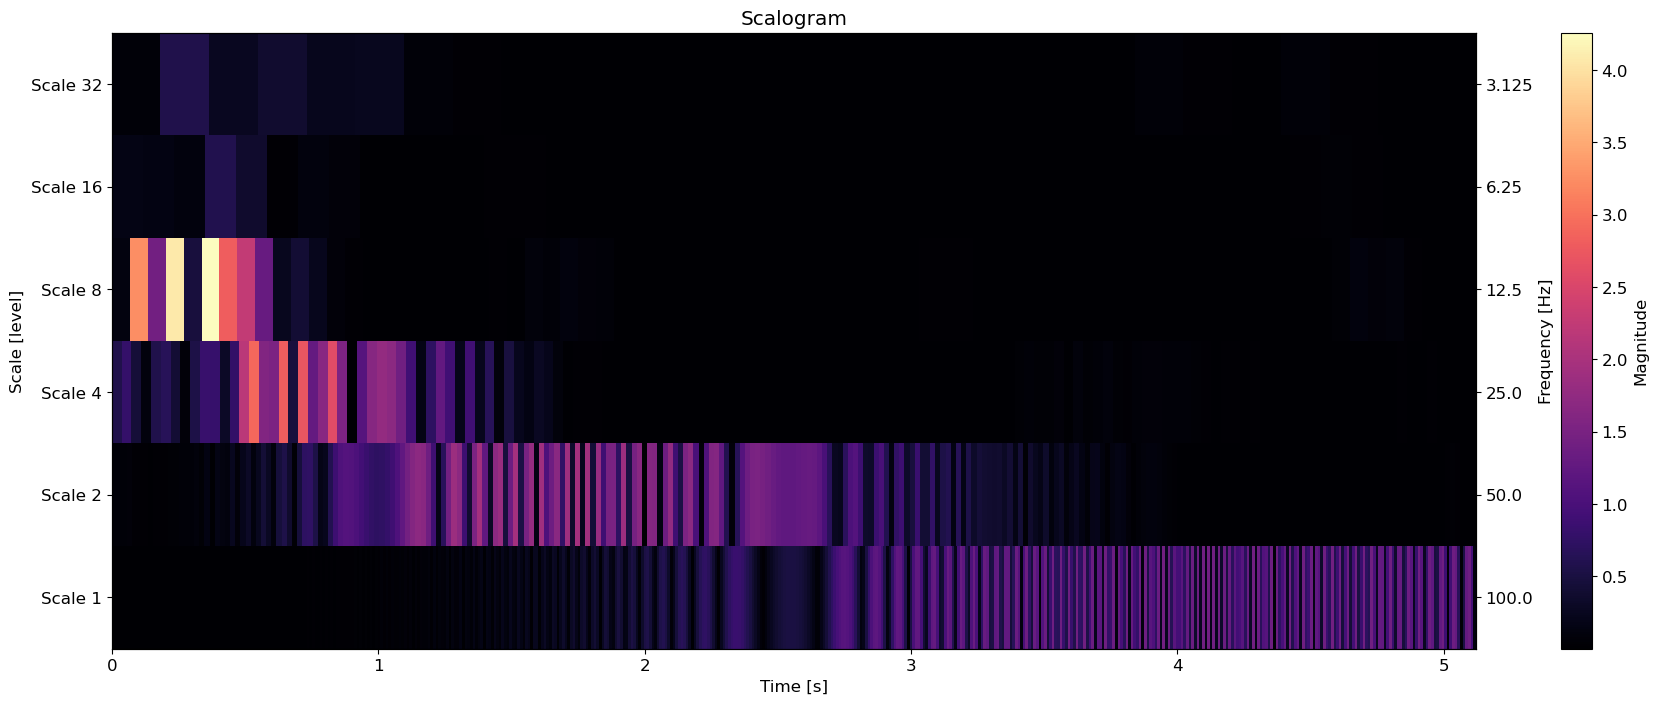

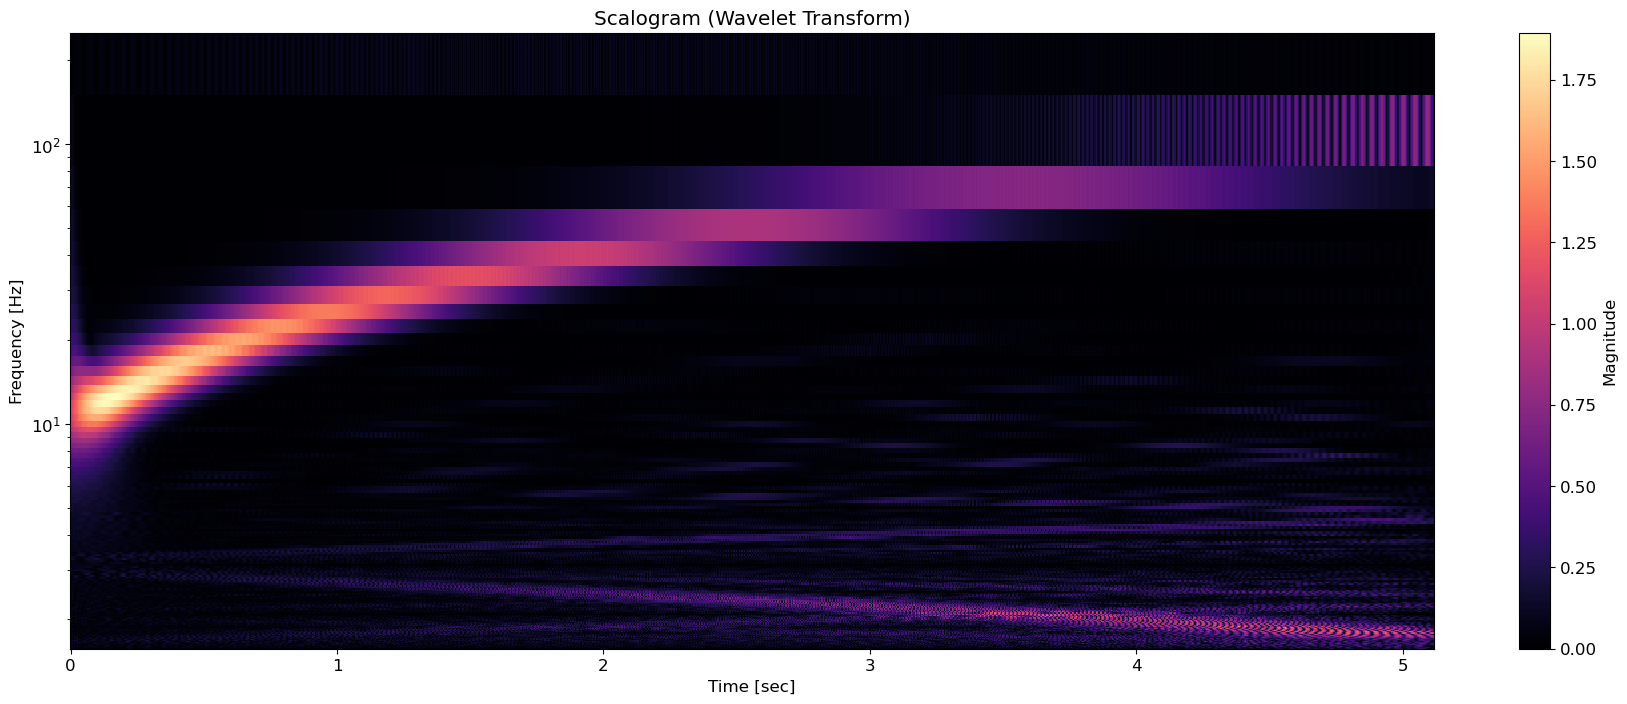

In [40]:
plot_dwt_scalogram(X, wv, fs)
plot_cwt_scalogram(X, fs)

## 2-frequency chirp
Secondly, the wavelet transform is tested when two chirps are superpositioned. Two frequency paths are expecte. We see that DWT scalogram has trouble with clear separation of two paths. CWT does much better on that.

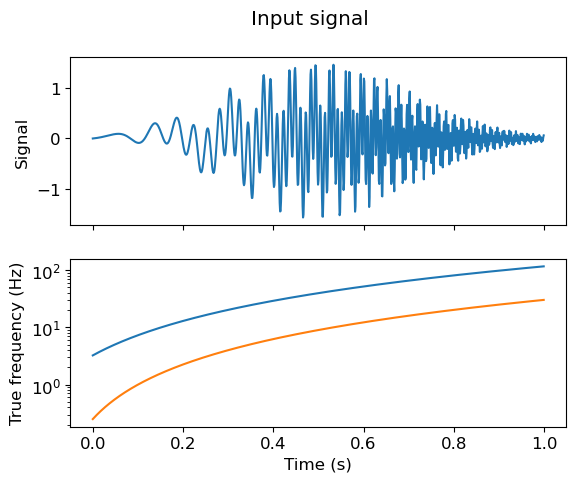

In [41]:
# Source: https://pywavelets.readthedocs.io/en/latest/ref/cwt.html

def gaussian(x, x0, sigma):
    return np.exp(-np.power((x - x0) / sigma, 2.0) / 2.0)


def make_chirp(t, t0, a):
    frequency = (a * (t + t0)) ** 2
    chirp = np.sin(2 * np.pi * frequency * t)
    return chirp, frequency


# generate signal
N = 2**10
fs = N
T = np.arange(N) / fs
chirp1, frequency1 = make_chirp(T, 0.2, 9)
chirp2, frequency2 = make_chirp(T, 0.1, 5)
X = chirp1 + 0.6 * chirp2
X *= gaussian(T, 0.5, 0.2)

fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(T, X)
axs[1].plot(T, frequency1)
axs[1].plot(T, frequency2)
axs[1].set_yscale("log")
axs[1].set_xlabel("Time (s)")
axs[0].set_ylabel("Signal")
axs[1].set_ylabel("True frequency (Hz)")
plt.suptitle("Input signal")
plt.show()

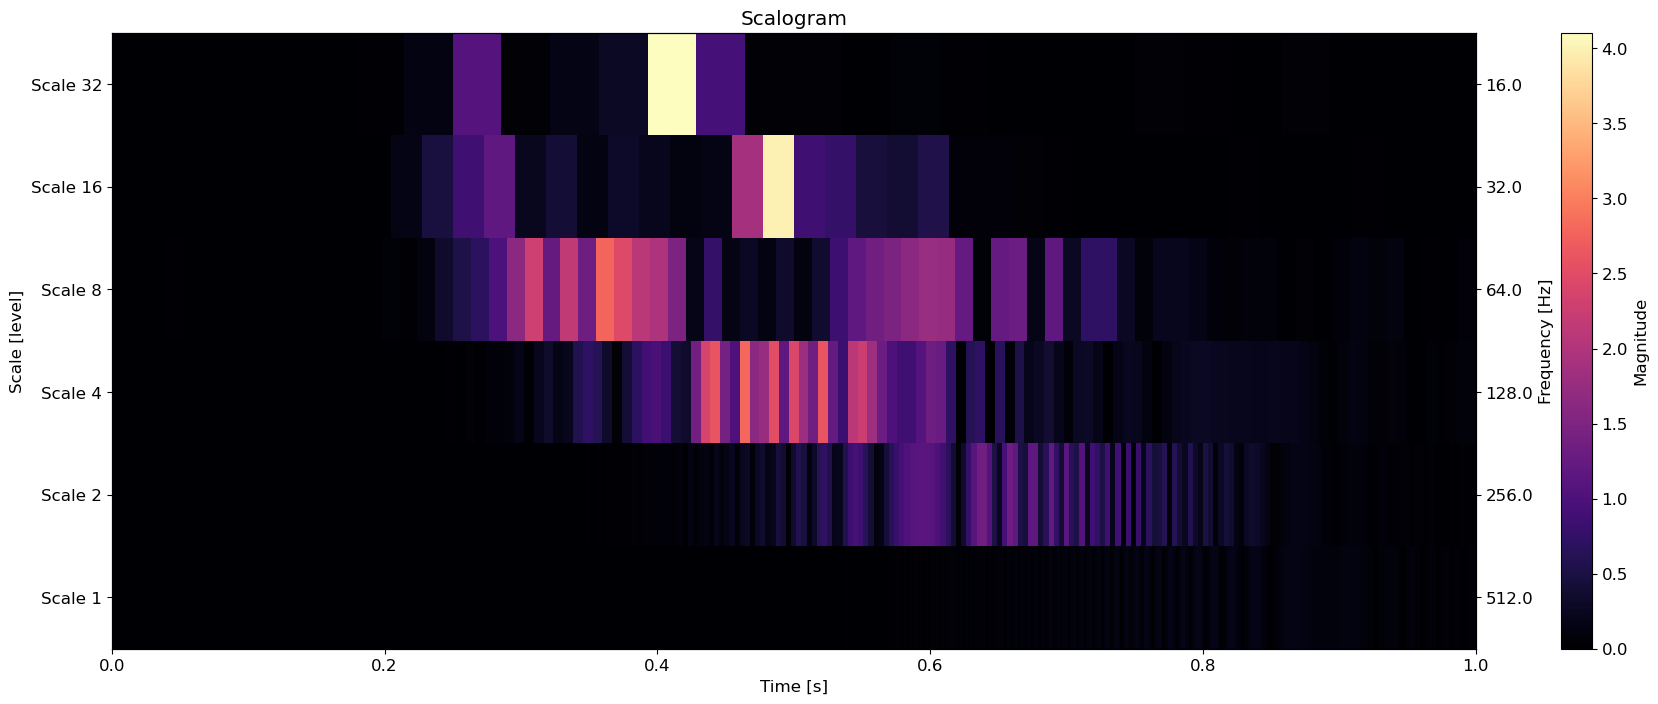

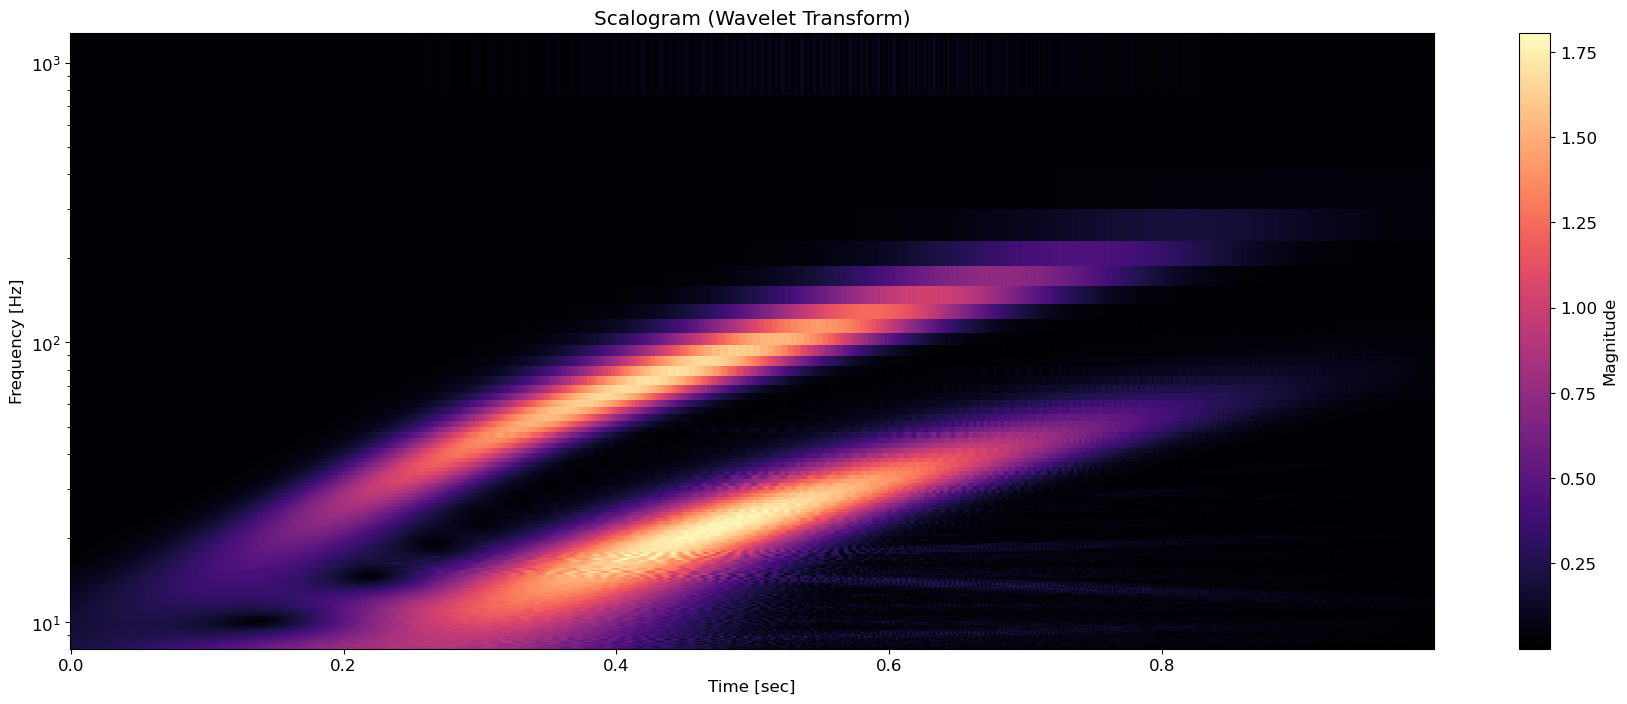

In [42]:
plot_dwt_scalogram(X, wv, fs)
plot_cwt_scalogram(X, fs)

# Natural speech data
As the main point of the exercise, natural speech is used. It is shown, that CWT allows for good data representation, that carries readable information about time evolution of the signal as well as about frequencies present in the signal

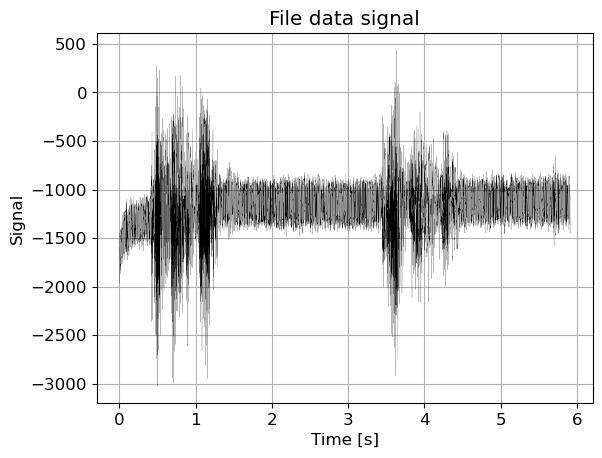

In [43]:
fs, X = wavfile.read('../sounds/rabarbar8k.wav')
T = np.arange(len(X)) / fs
plot_signal(X, T, 'File data signal')

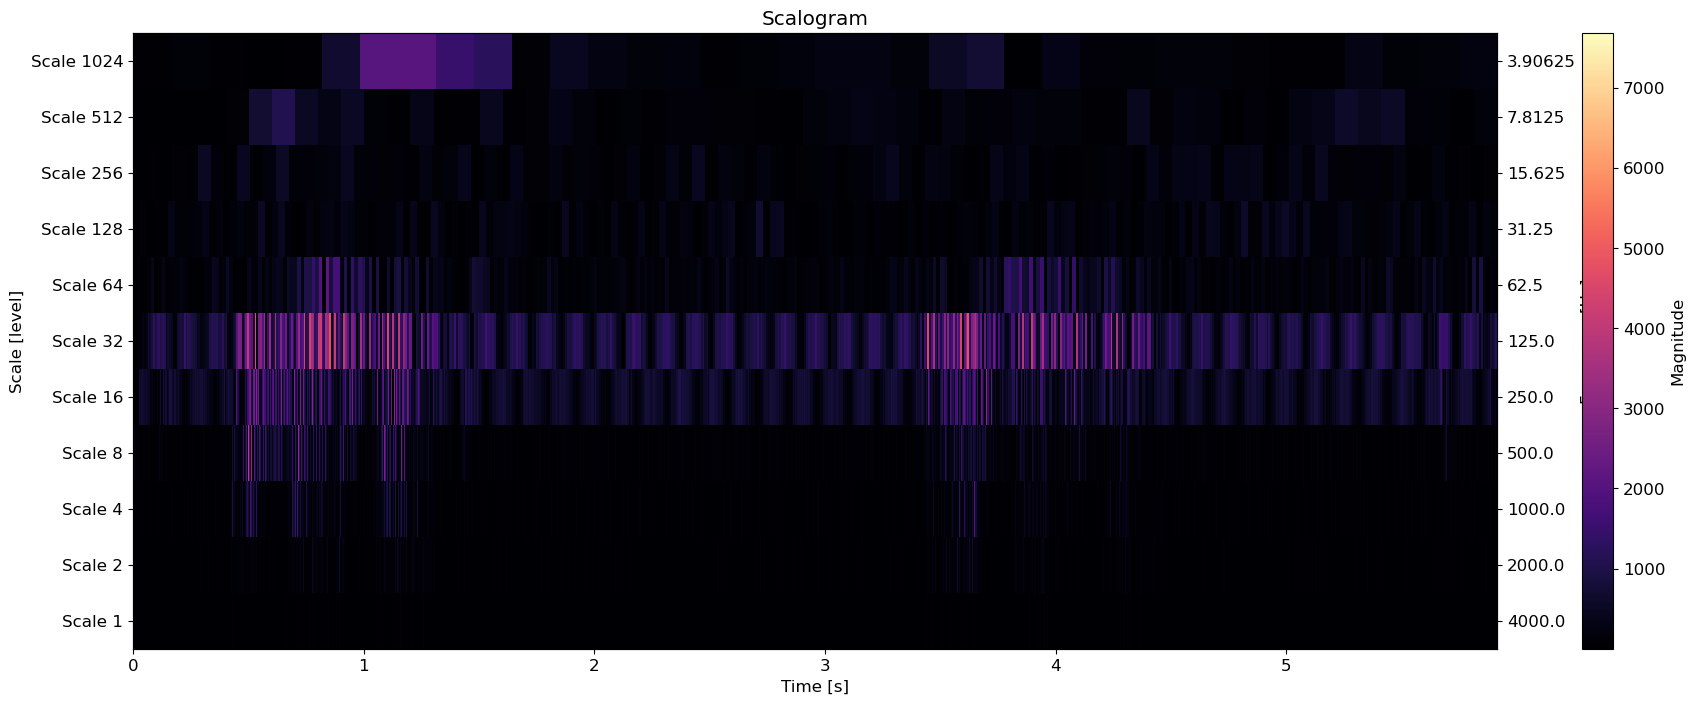

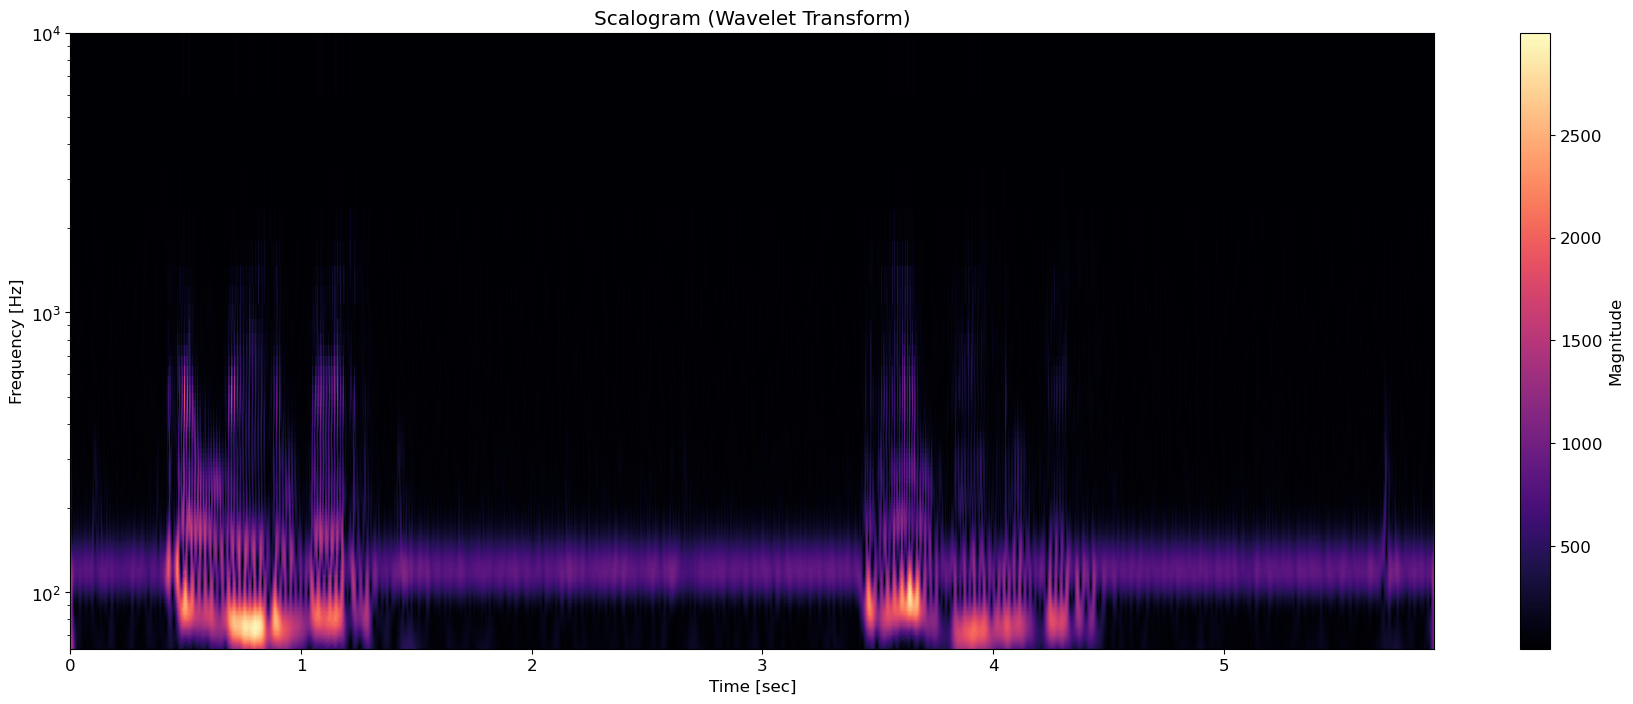

In [44]:
plot_dwt_scalogram(X, wv, fs)
plot_cwt_scalogram(X, fs)